# Group Members: 
 - Belen Saavedra
 - Evan Chapple
 - Fairooz Azim

# Libraries Importation

In [9]:
# Libraries 

from SPARQLWrapper import SPARQLWrapper, JSON
import wikipedia
from tqdm import tqdm
import os
import json
import pandas as pd
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import glob
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk import word_tokenize
import spacy
import stanza
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import stanza.pipeline
stanza.download('en')
import ast
import time
import re
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.error import HTTPError
from SPARQLWrapper.SPARQLExceptions import EndPointNotFound, QueryBadFormed, EndPointInternalError
import ast
import gc


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2024-06-15 16:01:48 INFO: Downloaded file to C:\Users\Salman\stanza_resources\resources.json
2024-06-15 16:01:48 INFO: Downloading default packages for language: en (English) ...
2024-06-15 16:01:51 INFO: File exists: C:\Users\Salman\stanza_resources\en\default.zip
2024-06-15 16:01:55 INFO: Finished downloading models and saved to C:\Users\Salman\stanza_resources


# Part 1: Comparing and clustering Texts

## Data Collection

Extract 100 biographies from Wikipedia with two main categories. 

Categories chosen:
1. Rabbi
2. Drag Queen

In [10]:
DATA_PATH = 'data/'
CATEGORY1 = 'Rabbi'
CATEGORY2 = 'Drag queen'

In [11]:
def get_people(profession):
    """
    Retrieves a list of people associated with a given profession from DBpedia.

    Input:
    - profession (str): The profession to query, e.g., 'Scientist', 'Actor'.

    Output:
    - list: A list of dictionaries containing details about each person associated with the specified profession.
    """
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    modified_profession = profession.replace(' ', '_').replace("'", '%27')
    query = """
            Select Distinct ?person Where {
                ?person dbo:occupation dbr:%s .
            }
            """ % modified_profession
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    ret = sparql.queryAndConvert()
    
    return ret['results']['bindings']


In [12]:
def get_rdf_triples(person):
    """
    Retrieves RDF triples for a given person from DBpedia.

    Input:
    - person (str): The name of the person to query, formatted as 'First_Last'.

    Output:
    - list: A list of dictionaries, each containing:
        - subject (str): The subject of the triple.
        - predicate (str): The predicate of the triple.
        - object (str): The object of the triple.
    """
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    dbpedia_resource = "http://dbpedia.org/resource/" + person
    query = "SELECT ?predicate ?object WHERE { <" + dbpedia_resource + "> ?predicate ?object.}"
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    triples = []
    for result in results["results"]["bindings"]:
        subj = "<" + dbpedia_resource + ">"
        pred = result["predicate"]["value"]
        obj = result["object"]["value"]
        triples.append({'subject': subj, 'predicate': pred, 'object': obj})
        
    return triples


In [13]:
def get_biographies(people, category, limit):
    """
    Retrieves and saves the biographies and RDF triples of a list of people.

    Input:
    - people (list): A list of dictionaries containing person details, typically from a SPARQL query result.
    - category (str): The category for naming the saved files, e.g., 'Scientist', 'Actor'.
    - limit (int): The maximum number of biographies to retrieve.

    Output:
    - list: A list of strings, each containing the biography content of a person.
    """
    pages = []
    i = 0
    if not os.path.exists(DATA_PATH):
        print('Data Directory did not exist, creating it now...')
        os.mkdir(DATA_PATH)
    with tqdm(total=limit) as pbar:
        while len(pages) < limit:
            if i >= len(people):
                break
            person = people[i]['person']['value'].split('/')[-1]
            try:
                page = wikipedia.page(person).content
                pages.append(page)
                file_path = os.path.join(DATA_PATH, person + '_' + category.replace(' ', '_'))
                with open(file_path + '.txt', 'w') as f:
                    f.write(page)
                triples = get_rdf_triples(person)
                with open(file_path + '.json', 'w') as f:
                    json.dump(triples, f, indent=4)
                pbar.update(1)
            except Exception as e:
                pass
            i += 1
            
    return pages

In [18]:
def create_dataset(cat1, cat2, limit=999):
    """
    Creates a dataset of biographies for two categories and returns the dataset along with individual texts.

    Input:
    - cat1 (str): The first category to query, e.g., 'Scientist'.
    - cat2 (str): The second category to query, e.g., 'Actor'.
    - limit (int, optional): The maximum number of biographies to retrieve for each category. Default is 999.

    Output:
    - tuple:
        - pd.DataFrame: A dataframe containing the biographies and their corresponding categories.
        - list: A list of texts for the first category.
        - list: A list of texts for the second category.
    """
    people1, people2 = (get_people(cat1), get_people(cat2))
    texts1, texts2 = (get_biographies(people1, cat1, limit), get_biographies(people2, cat2, limit))
    df = pd.DataFrame({'text' : texts1+texts2})
    df['category'] = pd.Series([cat1]*len(texts1) + [cat2]*len(texts2))
    
    return df, texts1, texts2


In [19]:
#Application of function to create main DataFrame to execution

df, texts1, texts2 = create_dataset(CATEGORY1, CATEGORY2, limit=100)
#CSV Generation of Raw Data
df.to_csv('0_raw_data.csv')

 65%|██████▌   | 65/100 [05:52<03:09,  5.43s/it]
c:\Users\Salman\AppData\Local\Programs\Python\Python311\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Salman\AppData\Local\Programs\Python\Python311\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
 93%|█████████▎| 93/100 [06:45<00:30,  4.36s/it]


## Data Analysis

### Text as input

Data Cleaning + Tokenization

In [20]:
def clean_text_complete(text):
    """
    Cleans the input text by removing specified punctuation and converting to lowercase.

    Input:
    - text (str): The text to be cleaned.

    Output:
    - str: The cleaned and lowercased text.
    """
    dirty_chars = '{}[]()|\/=+`"*,.<>;:#$%&' + "'"
    for char in dirty_chars:
        text = text.replace(char, ' ')
    return text.lower()

In [21]:
def tokenize(text):
    """
    Tokenizes the input text into words.

    Input:
    - text (str): The text to be tokenized.

    Output:
    - list: A list of tokens (words) extracted from the text.
    """
    return nltk.word_tokenize(text)


In [22]:
#Application of cleaning and tokenizing functions

df['clean_text'] = df['text'].apply(clean_text_complete)
df['tokenized'] = df['clean_text'].apply(tokenize)
#CSV format to save data
df.to_csv('1_tokenized_data.csv')

Vocabulary: 50 most frequent words and word cloud for each
category (Text)

In [23]:
def get_all_tokens(df, category):
    """
    Retrieves all tokens for a specified category from a dataframe.

    Input:
    - df (pd.DataFrame): The dataframe containing text data and their categories.
    - category (str): The category for which to retrieve tokens.

    Output:
    - list: A list of tokens for the specified category.
    """
    tokens = []
    for series in df[df["category"] == category]['tokenized']:
        for t in series:
            tokens.append(t)
    return tokens


In [12]:
#Execution of functions

tokens1 = get_all_tokens(df, CATEGORY1)
tokens2 = get_all_tokens(df, CATEGORY2)

In [24]:
def remove_stopwords(tokens, stop_words):
    """
    Removes stopwords from a list of tokens.

    Input:
    - tokens (list): A list of tokens.
    - stop_words (list): A list of stopwords.

    Output:
    - list: The list of tokens without stopwords.
    """
    for token in tokens:
        if token in stop_words:
            tokens.remove(token)
    return tokens


In [14]:
stopwords_en = stopwords.words('english') #I added into a list variable to fix the function.

In [15]:
tokens1_nostop = remove_stopwords(tokens1, stopwords_en)
tokens2_nostop = remove_stopwords(tokens2, stopwords_en)

In [16]:
def make_wordcloud(tokens, n_words, file_name):
    """
    Generates, displays, and saves a word cloud from a list of tokens.

    Input:
    - tokens (list): A list of tokens.
    - n_words (int): The number of most common words to include in the word cloud.
    - file_name (str): The name of the file to save the word cloud image.

    Output:
    - None: Displays the word cloud and saves it as an image file.
    """
    data = collections.Counter(tokens).most_common(n_words)
    word_frequencies = {word: freq for word, freq in data}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    wordcloud.to_file(file_name)


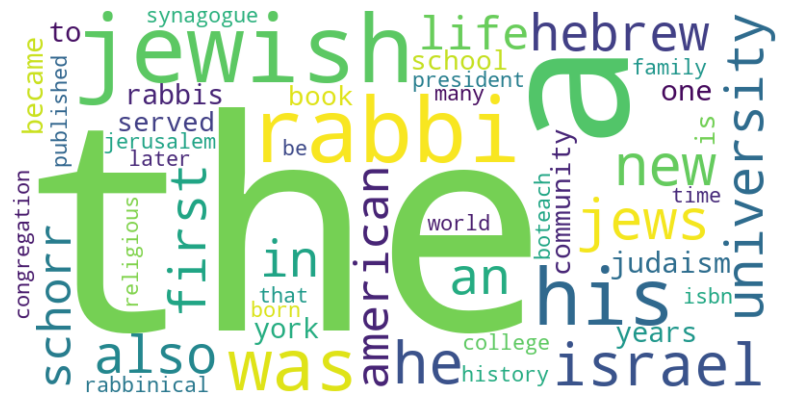

In [17]:
#Wordcloud for 'Rabbi' category

make_wordcloud(tokens1_nostop, 50,'Wordloud_Rabbi.png')

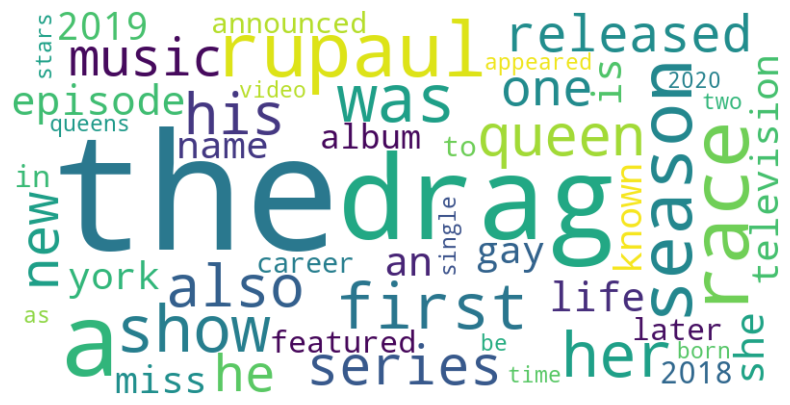

In [18]:
#Wordcloud for 'Drag Queen' category

make_wordcloud(tokens2_nostop, 50,'Worcloud_DragQueen.png')

Sentences: Min/max/avg number of sentences per category together with the corresponding histograms and box plots

In [19]:
def get_sentences(series):
    """
    Splits a series of text into individual sentences.

    Input:
    - series (pd.Series): A series of text strings.

    Output:
    - list: A list of sentences extracted from the text.
    """
    sentences = []
    for item in series:
        for para in item.split('\n'):
            for sent in nltk.sent_tokenize(para):
                sentences.append(sent)
    return sentences


In [20]:
#Applications of the functions

sentences1 = get_sentences(df[df['category'] == CATEGORY1]['text']) 
sentences2 = get_sentences(df[df['category'] == CATEGORY2]['text'])

In [21]:
def get_length_dict(sentences):
    """
    Analyzes the lengths of sentences and returns various statistics.

    Input:
    - sentences (list): A list of sentences.

    Output:
    - tuple:
        - dict: A dictionary with sentence lengths as keys and their frequencies as values.
        - list: An expanded list where each length appears as many times as its frequency.
        - str: The longest sentence.
        - str: The shortest sentence.
    """
    lengths = {}
    longest_sentence = ""
    shortest_sentence = "Pretty sure it's smaller than this"
    for sentence in sentences:
        len_sentence = len(sentence.split(' '))
        if len_sentence > len(longest_sentence.split(' ')):
            longest_sentence = sentence
        if len_sentence < len(shortest_sentence.split(' ')):
            shortest_sentence = sentence
        if lengths.get(len_sentence):
            lengths[len_sentence] += 1
        else:
            lengths[len_sentence] = 1
    expanded = []
    for key, count in lengths.items():
        expanded.extend([key] * count)
    return lengths, expanded, longest_sentence, shortest_sentence


In [22]:
#Applications of the function

length_sentence1, expanded1, longest_sentence1, shortest_sentence1 = get_length_dict(sentences1)
length_sentence2, expanded2, longest_sentence2, shortest_sentence2 = get_length_dict(sentences2)

In [23]:
#Visualization of metrics

print('Min Sentence Length Category 1:', min(length_sentence1))
print('Max Sentence Length Category 1:', max(length_sentence1))
print('Avg Sentence Length Category 1:', sum(length_sentence1) / len(length_sentence1))
print('Min Sentence Length Category 2:', min(length_sentence2))
print('Max Sentence Length Category 2:', max(length_sentence2))
print('Avg Sentence Length Category 2:', sum(length_sentence2) / len(length_sentence2))

Min Sentence Length Category 1: 1
Max Sentence Length Category 1: 129
Avg Sentence Length Category 1: 45.1764705882353
Min Sentence Length Category 2: 1
Max Sentence Length Category 2: 108
Avg Sentence Length Category 2: 39.38666666666666


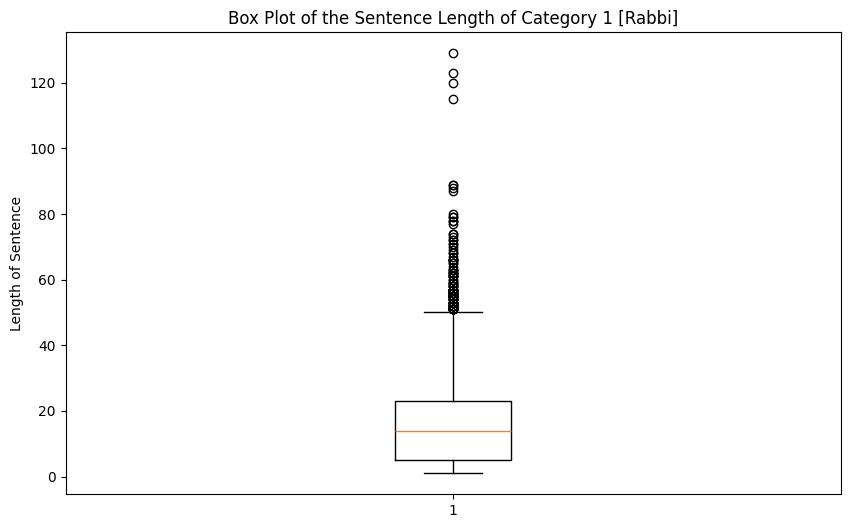

In [24]:
#Boxplot for sentence length for Rabbi

plt.figure(figsize=(10, 6))
plt.boxplot(expanded1)
plt.title("Box Plot of the Sentence Length of Category 1 [Rabbi]")
plt.ylabel("Length of Sentence")
plt.savefig('Boxplot_Sentence_Lenght_Rabbi.png')
plt.show()


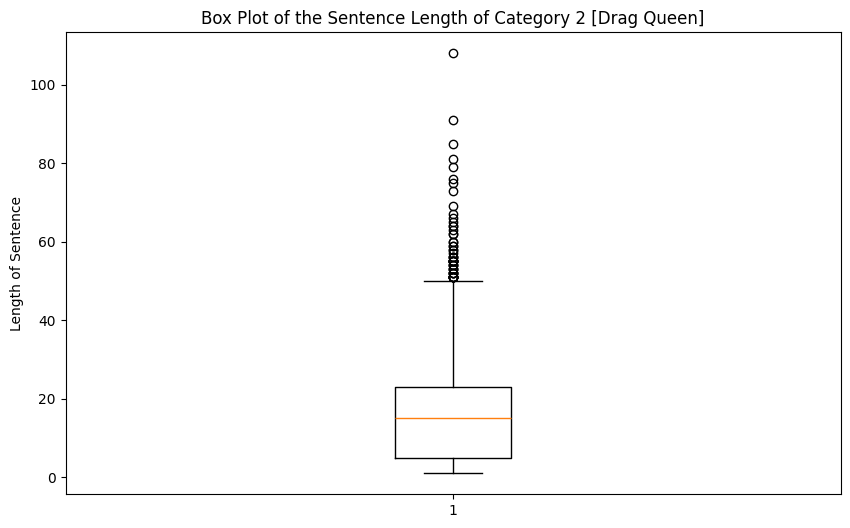

In [25]:
#Boxplot for sentence length for Drag Queen

plt.figure(figsize=(10, 6))
plt.boxplot(expanded2)
plt.title("Box Plot of the Sentence Length of Category 2 [Drag Queen]")
plt.ylabel("Length of Sentence")
plt.savefig('Boxplot_Sentence_Lenght_DragQueen.png')
plt.show()


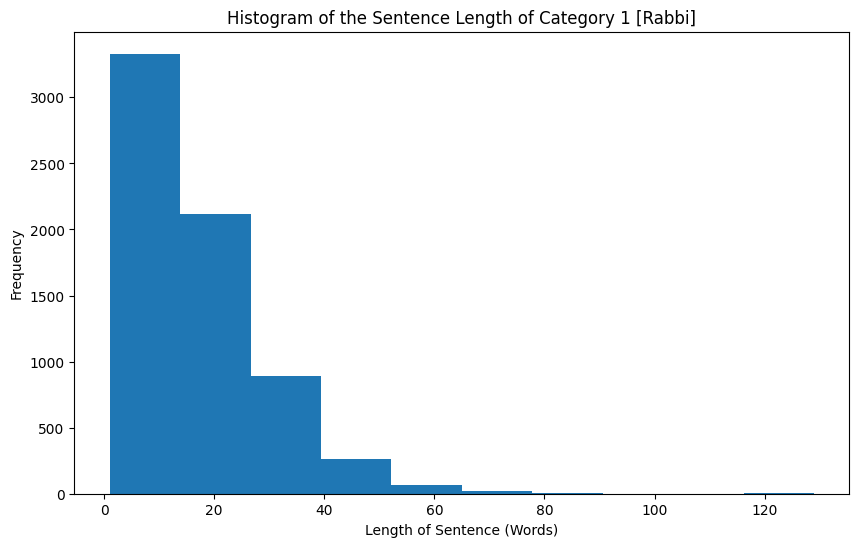

In [26]:
#Histogram for Rabbi

plt.figure(figsize=(10, 6))
plt.hist(expanded1)
plt.title("Histogram of the Sentence Length of Category 1 [Rabbi]")
plt.ylabel("Frequency")
plt.xlabel("Length of Sentence (Words)")
plt.savefig('Histogram_Sentence_Lenght_Rabbi.png')
plt.show()


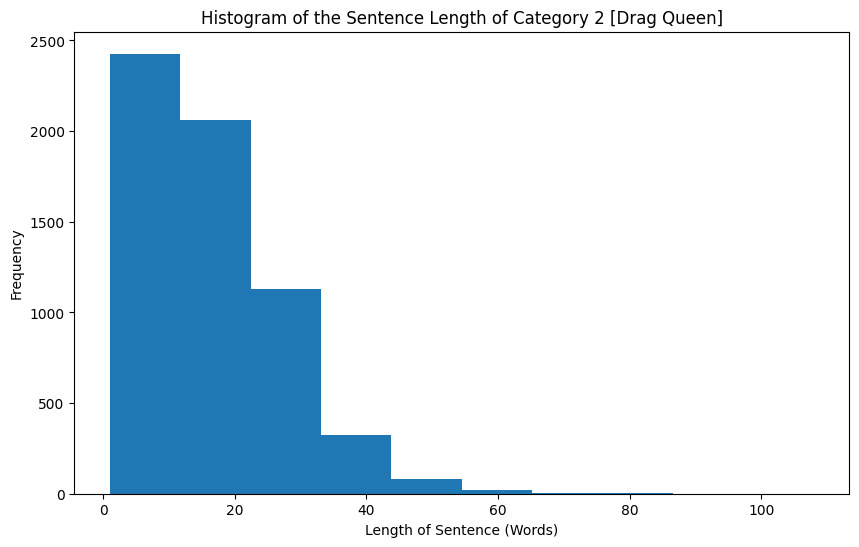

In [27]:
#Histogram for Drag Queen

plt.figure(figsize=(10, 6))
plt.hist(expanded2)
plt.title("Histogram of the Sentence Length of Category 2 [Drag Queen]")
plt.ylabel("Frequency")
plt.xlabel("Length of Sentence (Words)")
plt.savefig('Histogram_Sentence_Lenght_DragQueen.png')
plt.show()


Tokens: Total number of bi-gram occurrences per category. Min/max/avg
number of bi-gram occurrences per sentence per category

In [28]:
def collect_bigrams(tokens):
    """
    Collects and counts the occurrences of bigrams in a list of tokens.

    Input:
    - tokens (list): A list of tokens.

    Output:
    - dict: A dictionary with bigrams as keys and their frequencies as values.
    """
    bigrams = nltk.bigrams(tokens)
    occurences = {}
    for bigram in bigrams:
        if occurences.get(bigram):
            occurences[bigram] += 1
        else:
            occurences[bigram] = 1
    return occurences


In [29]:
#Execution for bigrams I

bigrams1 = collect_bigrams(tokens1)
bigrams2 = collect_bigrams(tokens2)

In [30]:
#Execution for bigrams II
bigrams_longest1 = collect_bigrams(longest_sentence1.split(' '))
bigrams_longest2 = collect_bigrams(longest_sentence2.split(' '))

In [31]:
#Execution for bigrams III
bigrams_shortest1 = collect_bigrams(shortest_sentence1.split(' '))
bigrams_shortest2 = collect_bigrams(shortest_sentence2.split(' '))

In [32]:
#Visualization of statistics

print("Number of unique bigram occurences in Category 1:", len(bigrams1))
print("\tUnique bigrams in shortest:\t\t", len(bigrams_shortest1))
print("\tUnique bigrams in longest:\t\t", len(bigrams_longest1))
print("Number of unique bigram occurences in Category 2:", len(bigrams2))
print("\tUnique bigrams in shortest:\t\t", len(bigrams_shortest1))
print("\tUnique bigrams in longest:\t\t", len(bigrams_longest1))

Number of unique bigram occurences in Category 1: 58372
	Unique bigrams in shortest:		 0
	Unique bigrams in longest:		 116
Number of unique bigram occurences in Category 2: 47905
	Unique bigrams in shortest:		 0
	Unique bigrams in longest:		 116


### RDF Graph as input

RDF properties: 50 most frequent properties and property cloud
for each category

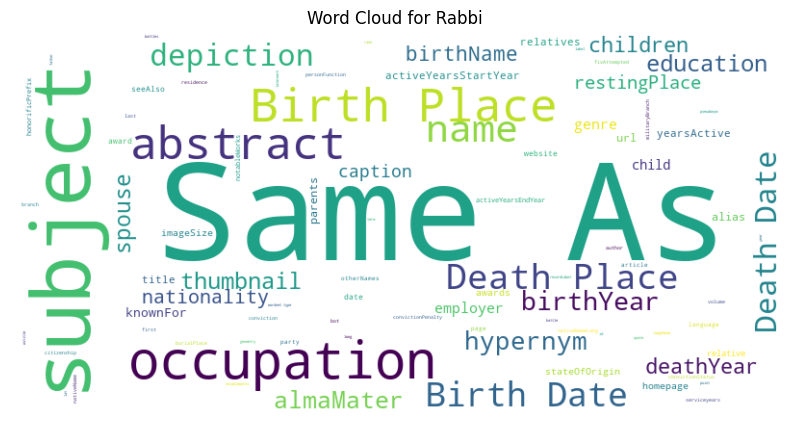

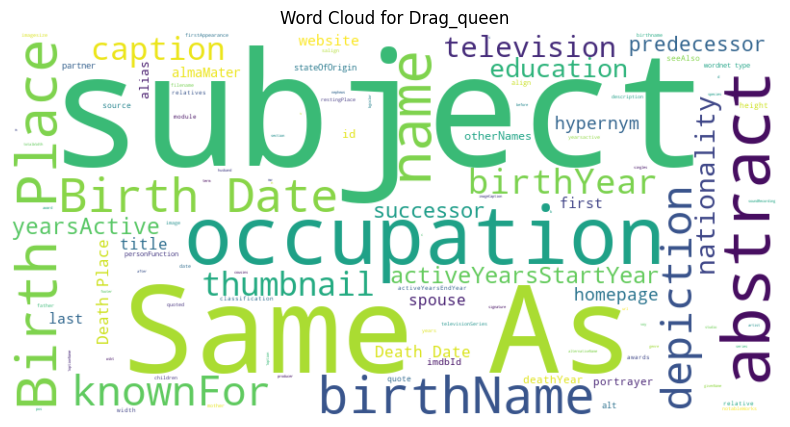

In [25]:
def load_data(category):
    """
    Loads and aggregates JSON data files for a given category.

    Input:
    - category (str): The category used to filter files.

    Output:
    - list: A list of data loaded from the JSON files.
    """
    files = glob.glob(f'./data/*{category}*.json') 
    data = []
    for file in files:
        with open(file, 'r') as f:
            data.extend(json.load(f))
    return data

def format_property_name(uri):
    """
    Formats a URI into a more readable property name.

    Input:
    - uri (str): The URI to be formatted.

    Output:
    - str: The formatted property name.
    """
    name = uri.split('/')[-1]
    name = name.split('#')[-1]
    name = name.replace('_', ' ')
    replacements = {
        'PageID': 'Page ID',
        'URL': 'URL',
        'birthDate': 'Birth Date',
        'deathDate': 'Death Date',
        'birthPlace': 'Birth Place',
        'deathPlace': 'Death Place',
        'sameAs': 'Same As'
    }
    for key, value in replacements.items():
        name = name.replace(key, value)
    return name

def count_properties(data, exclude):
    """
    Counts the occurrences of properties in the data, excluding specified URIs.

    Input:
    - data (list): A list of triples containing property URIs.
    - exclude (list): A list of property URIs to exclude from the count.

    Output:
    - Counter: A counter object with property names as keys and their frequencies as values.
    """
    property_counter = Counter()
    for triple in data:
        property_uri = triple['predicate']
        if property_uri not in exclude:
            simple_property_name = format_property_name(property_uri)
            property_counter[simple_property_name] += 1
    return property_counter

def make_wordcloud(properties_counter, category, file_name):
    """
    Generates, displays, and saves a word cloud from a property counter.

    Input:
    - properties_counter (Counter): A counter object with property names and their frequencies.
    - category (str): The category for the title of the word cloud.
    - file_name (str): The name of the file to save the word cloud image.

    Output:
    - None: Displays the word cloud and saves it as an image file.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(properties_counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()

    # Save the word cloud image to a file
    wordcloud.to_file(file_name)

exclusions = [
    "http://dbpedia.org/ontology/wikiPageExternalLink",
    "http://dbpedia.org/ontology/wikiPageRevisionID",
    "http://dbpedia.org/ontology/wikiPageWikiLink",
    "http://dbpedia.org/property/wikiPageUsesTemplate",
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    "http://www.w3.org/2000/01/rdf-schema#label",
    "http://www.w3.org/2000/01/rdf-schema#comment",
    "http://dbpedia.org/ontology/wikiPageLength",
    "http://dbpedia.org/ontology/wikiPageID",
    "http://xmlns.com/foaf/0.1/isPrimaryTopicOf",
    "http://www.w3.org/ns/prov#wasDerivedFrom"
]

for category in ['Rabbi', 'Drag_queen']:
    data = load_data(category)
    properties = count_properties(data, exclusions)
    file_name = f'Wordcloud_{category}_RDF.png'
    make_wordcloud(properties, category, file_name)



 Facts: Min/max/avg number of facts per category together. Histograms and box plots for number of facts per graph for each
category

Statistics for Rabbi:
Minimum facts: 62
Maximum facts: 9092
Average facts: 235.75


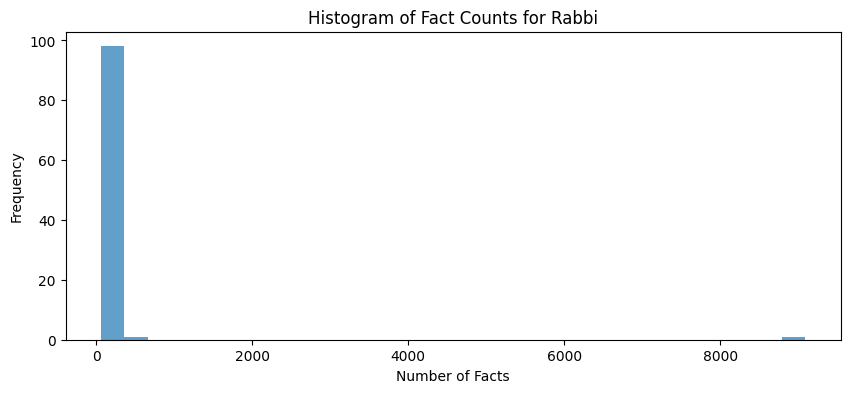

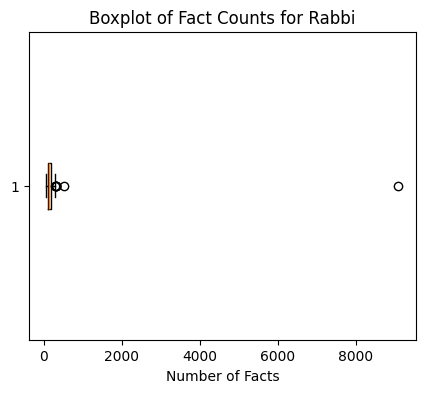

Statistics for Drag_queen:
Minimum facts: 14
Maximum facts: 716
Average facts: 149.47524752475246


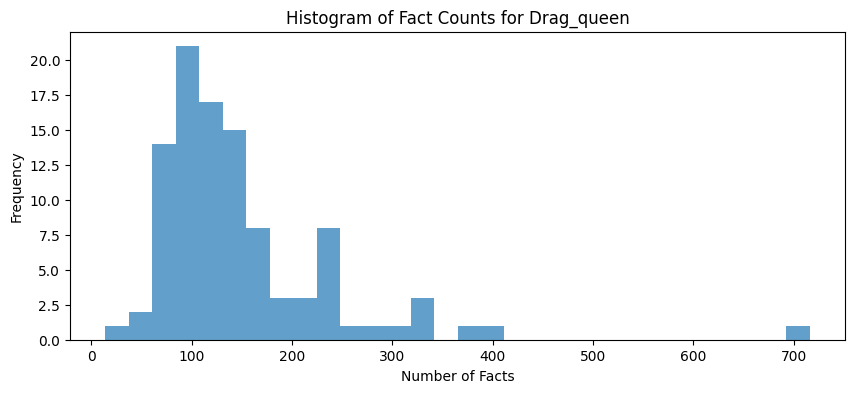

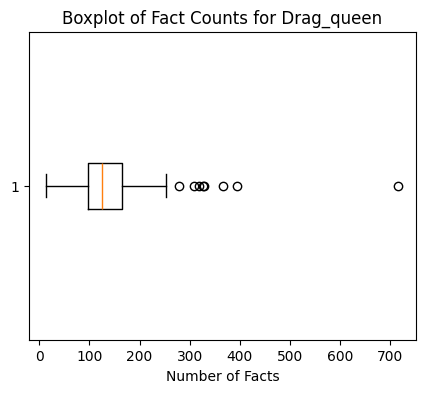

In [35]:
def load_and_count_facts(category):
    """
    Loads JSON data files for a given category and counts unique facts.

    Input:
    - category (str): The category used to filter files.

    Output:
    - list: A list of counts of unique facts for each file.
    """
    files = glob.glob(f'./data/*{category}*.json')
    fact_counts = []
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
        unique_facts = set((fact['subject'], fact['predicate'], fact['object']) for fact in data)
        fact_counts.append(len(unique_facts))
    return fact_counts

def visualize_data(categories):
    """
    Visualizes data for multiple categories by plotting histograms and boxplots of fact counts.

    Input:
    - categories (list): A list of categories to visualize.

    Output:
    - None: Displays histograms and boxplots for each category.
    """
    for category in categories:
        fact_counts = load_and_count_facts(category)
        print(f"Statistics for {category}:")
        print(f"Minimum facts: {min(fact_counts)}")
        print(f"Maximum facts: {max(fact_counts)}")
        print(f"Average facts: {sum(fact_counts) / len(fact_counts)}")

        plt.figure(figsize=(10, 4))
        plt.hist(fact_counts, bins=30, alpha=0.7, label=f'{category} Facts')
        plt.title(f'Histogram of Fact Counts for {category}')
        plt.xlabel('Number of Facts')
        plt.ylabel('Frequency')
        plt.savefig(f'Histogram_RDF_{category}.png')
        plt.show()
        

        plt.figure(figsize=(5, 4))
        plt.boxplot(fact_counts, vert=False)
        plt.title(f'Boxplot of Fact Counts for {category}')
        plt.xlabel('Number of Facts')
        plt.savefig(f'Boxplot_RDF_{category}.png')
        plt.show()
        


categories = ['Rabbi', 'Drag_queen'] # For some reason the Rabbi's graphs look *awful*

visualize_data(categories)



In [26]:
def load_and_linearize(category):
    """
    Loads RDF data for a given category and linearizes it into a list of strings.

    Input:
    - category (str): The category used to filter files.

    Output:
    - list: A list of linearized RDF triples as strings.
    """
    path_pattern = f'./data/*{category}*.json'
    linearized_data = []

    for file_path in glob.glob(path_pattern):
        with open(file_path, 'r') as file:
            data = json.load(file)
            for triple in data:
                subject = extract_and_clean(triple['subject'])
                predicate = extract_and_clean(triple['predicate'])
                object_ = extract_and_clean(triple['object'])
                linearized_string = f"{subject} {predicate} {object_}"
                linearized_data.append(linearized_string)

    return linearized_data

def extract_and_clean(uri):
    """
    Extracts and cleans the last part of a URI by replacing underscores and hyphens with spaces.

    Input:
    - uri (str): The URI to be cleaned.

    Output:
    - str: The cleaned URI part.
    """
    parts = uri.split('/')
    last_part = parts[-1]
    if '#' in last_part:
        last_part = last_part.split('#')[-1]
    return last_part.replace('_', ' ').replace('-', ' ')

categories = ['Rabbi', 'Drag_queen']
linearized_data = {}

for category in categories:
    linearized_data[category] = load_and_linearize(category)

linearized_rabbi = linearized_data['Rabbi']
linearized_drag_queen = linearized_data['Drag_queen']

# To clean the elements of each list
# remove repetitions
linearized_rabbi_rdf = list(set(linearized_rabbi))
linearized_drag_queen_rdf = list(set(linearized_drag_queen))

# remove '>' symbol
linearized_rabbi_rdf = [re.sub('>', '', rabbi) for rabbi in linearized_rabbi_rdf]
linearized_drag_queen_rdf = [re.sub('>', '', dg) for dg in linearized_drag_queen_rdf]



In [27]:
# Creating a separate data frame with the RDFs

df_rabbi = pd.DataFrame({'text': linearized_rabbi_rdf, 'category': 'Rabbi'})

# Create DataFrame for Drag Queen texts
df_drag_queen = pd.DataFrame({'text': linearized_drag_queen_rdf, 'category': 'Drag Queen'})

# Concatenate both DataFrames into a single DataFrame
df_rdf = pd.concat([df_rabbi, df_drag_queen], ignore_index=True)

# Shuffle the DataFrame if needed
df_rdf = df_rdf.sample(frac=1, random_state=42)
df_rdf = shuffle(df_rdf)
df_rdf = df_rdf.reset_index(drop=True) 
df_rdf.to_csv('2_RDF_Linearized_data.csv')

## Clustering

Train KMeans clustering (n_clusters=2). Cluster based on text and, separately, on facts

### Clustering based on text 

In [38]:
#Shuffling the dataframe for better training
df_shuffled = df.sample(frac=1).reset_index(drop=True) 

df_shuffled.head()

df_shuffled.to_csv('3_Shuffled_Data.csv')

In [39]:
#Adding Numerical categories

#defining custom mapping
category_mapping = { "Drag queen": 0, "Rabbi" : 1}

#applying to df
df_shuffled['numerical_category'] = df_shuffled['category'].map(category_mapping)
df_shuffled.head()

,text,category,clean_text,tokenized,numerical_category
0,Rabbi Menachem Froman (also spelled Menahem an...,Rabbi,rabbi menachem froman also spelled menahem an...,"[rabbi, menachem, froman, also, spelled, menah...",1
1,"Derrick Prentice Barry (born July 18, 1983) is...",Drag queen,derrick prentice barry born july 18 1983 is...,"[derrick, prentice, barry, born, july, 18, 198...",0
2,Sholem Ber Hecht (born 1946) is an American Ch...,Rabbi,sholem ber hecht born 1946 is an american ch...,"[sholem, ber, hecht, born, 1946, is, an, ameri...",1
3,"Rabbi Baruch Myers (born May 2, 1964, in Orang...",Rabbi,rabbi baruch myers born may 2 1964 in orang...,"[rabbi, baruch, myers, born, may, 2, 1964, in,...",1
4,Marcus Solomon is an Australian jurist and rab...,Rabbi,marcus solomon is an australian jurist and rab...,"[marcus, solomon, is, an, australian, jurist, ...",1


In [40]:
#Vectorizing Inputs [TF-IDF]

X = df_shuffled['clean_text']
Y = df_shuffled['numerical_category']
X

0      rabbi menachem froman  also spelled menahem an...
1      derrick prentice barry  born july 18  1983  is...
2      sholem ber hecht  born 1946  is an american ch...
3      rabbi baruch myers  born may 2  1964  in orang...
4      marcus solomon is an australian jurist and rab...
                             ...                        
195    samuel adler  december 3  1809 – june 9  1891 ...
196    stuart weinblatt is an ordained rabbi and the ...
197    arthur ocean waskow  born arthur i  waskow  19...
198    alexander j  michaels  born october 16  1983  ...
199    george boyle  born 22 september 1996   better ...
Name: clean_text, Length: 200, dtype: object

In [41]:
# Splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [42]:
# Using TFIDF vectorizer to convert convert words to Vector Space
tfidf_vectorizer = TfidfVectorizer(max_features=500,
                                       use_idf=True,
                                       stop_words='english')
                                       #tokenizer=nltk.word_tokenize)
#                                       ngram_range=(1, 2))

# Fit the vectorizer to text data
X_train_vectors= tfidf_vectorizer.fit_transform(X_train)
X_test_vectors= tfidf_vectorizer.fit_transform(X_test)
X_vectors = tfidf_vectorizer.fit_transform(X)

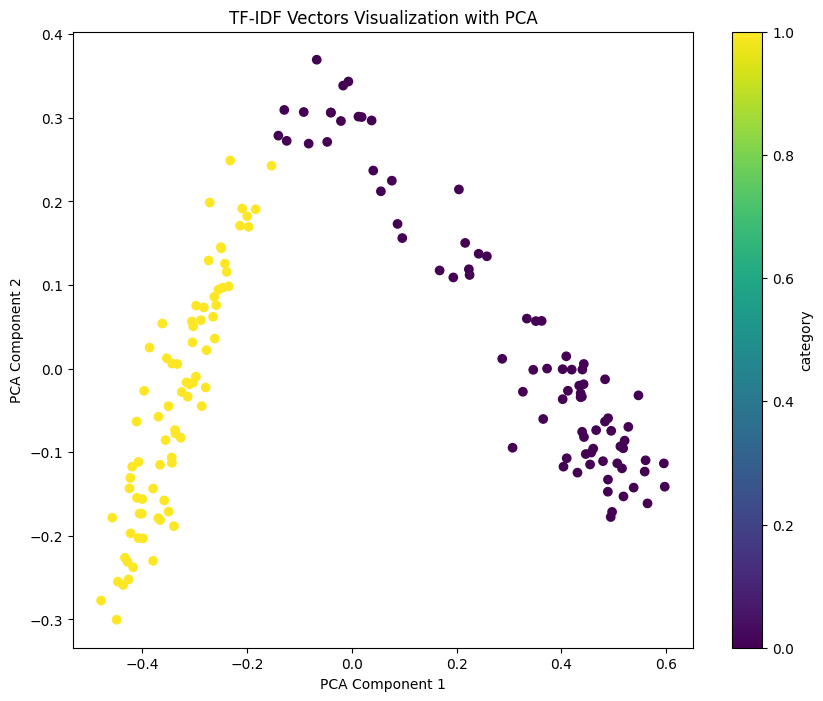

In [43]:

# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_pca = pca.fit_transform(X_train_vectors.toarray())

# Plot PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Visualization with PCA')
plt.colorbar(label='category')
plt.savefig('TF_IDF_PCA.png')
plt.show()



In [44]:
#Training a K-means clustering model

# Kmeans++
km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=3425)
km.fit(X_train_vectors)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels = km.labels_
clusters = predicted_labels.tolist()



In [45]:
train_data = {'text': X_train, 'category': y_train, 'cluster' : clusters}
df_train = pd.DataFrame(train_data,columns=['text','category','cluster'])
df_train

,text,category,cluster
79,nelson glueck june 4 1900 – february 12 197...,1,1
197,arthur ocean waskow born arthur i waskow 19...,1,1
38,simon greenberg 1901 – july 26 1993 was a r...,1,1
24,christopher delmar caldwell born june 22 198...,0,0
122,scarlett harlett is the stage name of harry lu...,0,0
...,...,...,...
106,antonio pantojas november 25 1948 – october ...,0,1
14,moses vita ascarelli hebrew משה יחיאל עזכארי...,1,1
92,justin omar mooijer born 9 april 1992 known...,0,0
179,moshe feinstein hebrew משה פײַנשטיין lithua...,1,1


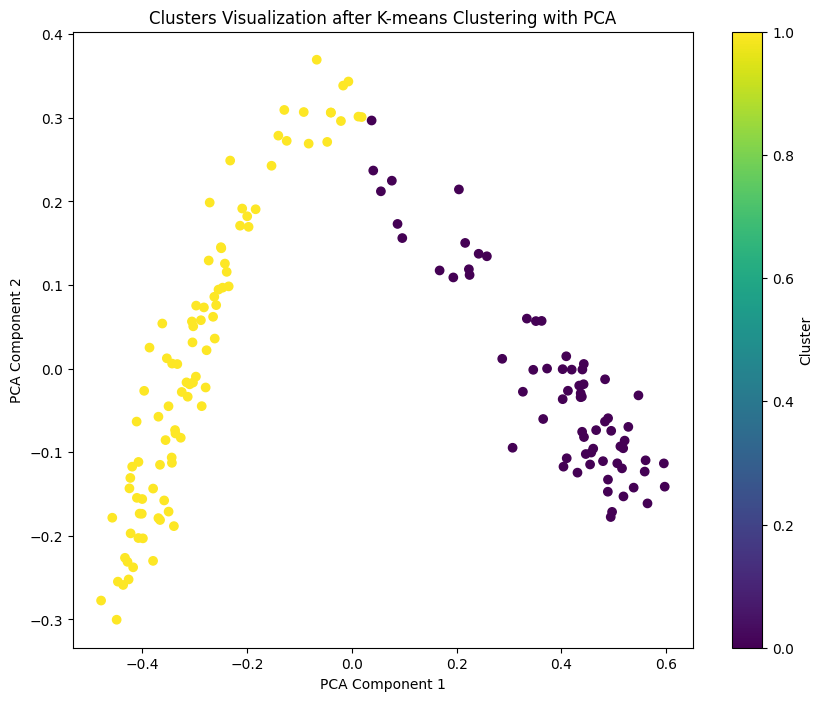

In [46]:
# Reducing the dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_train_vectors.toarray())

# Clusters plot
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization after K-means Clustering with PCA')
plt.colorbar(label='Cluster')
plt.savefig('Clusters_K-means_PCA.png')
plt.show()


#### Compute supervised and unsupervised metrics and visualizations to compare results

In [47]:
#Supervised Metrics and Unsupervised Metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, predicted_labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, predicted_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, predicted_labels))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_train, predicted_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X_train_vectors, predicted_labels))



Homogeneity: 0.646
Completeness: 0.656
V-measure: 0.651
Adjusted Rand-Index: 0.679
Silhouette Coefficient: 0.123


### Clustering based on facts

In [30]:
#Adding Numerical categories

#defining custom mapping
category_mapping = { "Drag Queen": 0, "Rabbi" : 1}

#applying to df
df_rdf['numerical_category'] = df_rdf['category'].map(category_mapping)
df_rdf.tail()

,text,category,numerical_category
36841,Monét X Change birthPlace New York City,Drag Queen,0
36842,Josy Eisenberg sameAs 1122653115,Rabbi,1
36843,Yvie Oddly wikiPageWikiLink Alexander McQueen,Drag Queen,0
36844,Henry Barnston wikiPageWikiLink Queen Victoria,Rabbi,1
36845,Yvie Oddly wikiPageWikiLink RuPaul,Drag Queen,0


In [31]:
X_rdf = df_rdf['text']
Y_rdf = df_rdf['numerical_category']
X_rdf

0        RuPaul abstract RuPaul, nom artístic de RuPaul...
1        Zvi Hirsch Kalischer abstract تسفي هيرش كاليشر...
2                          Josy Eisenberg sameAs 114177082
3        Theodore Friedman subject Category:Israeli col...
4        Josy Eisenberg comment Francis R. Nicosia är p...
                               ...                        
36841              Monét X Change birthPlace New York City
36842                     Josy Eisenberg sameAs 1122653115
36843        Yvie Oddly wikiPageWikiLink Alexander McQueen
36844       Henry Barnston wikiPageWikiLink Queen Victoria
36845                   Yvie Oddly wikiPageWikiLink RuPaul
Name: text, Length: 36846, dtype: object

In [32]:
# Split the data into training and testing sets
X_train_rdf, X_test_rdf, y_train_rdf, y_test_rdf = train_test_split(X_rdf, Y_rdf, test_size=0.2, random_state=42)

In [33]:
# Using TFIDF vectorizer to convert convert words to Vector Space
tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                       use_idf=True,
                                       stop_words='english')
                                       #tokenizer=nltk.word_tokenize)
#                                       ngram_range=(1, 2))

# Fitting the vectorizer to text data
X_train_rdf_vec= tfidf_vectorizer.fit_transform(X_train_rdf)
X_test_rdf_vec= tfidf_vectorizer.fit_transform(X_test_rdf)
X_rdf_vec = tfidf_vectorizer.fit_transform(X_rdf)

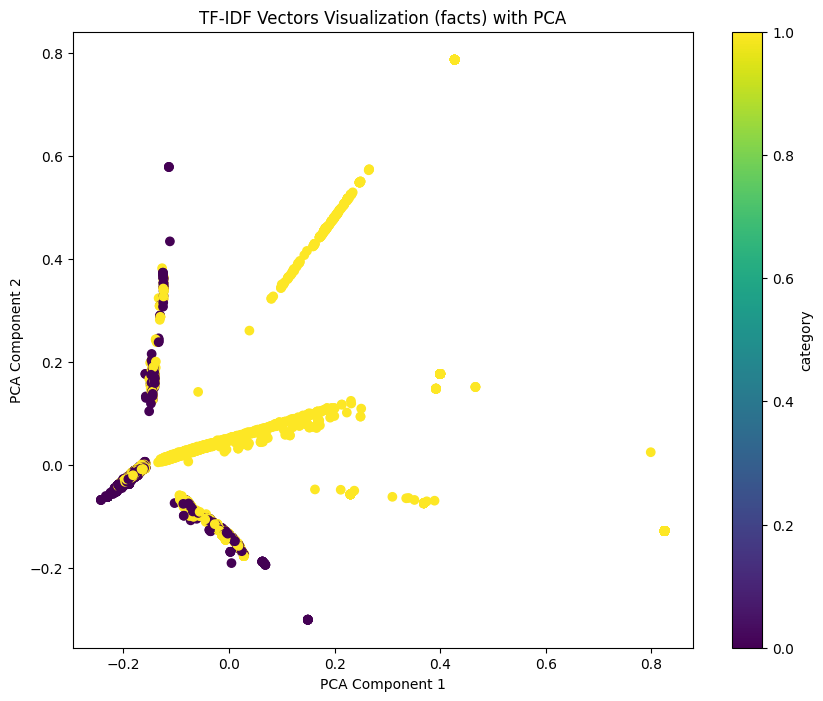

In [34]:
# Reducing dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2) 
X_rdf_pca = pca.fit_transform(X_train_rdf_vec.toarray())

# Plotting PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_rdf_pca[:, 0], X_rdf_pca[:, 1], c=y_train_rdf, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Visualization (facts) with PCA')
plt.colorbar(label='category')
plt.savefig('TF_IDF_FACTS_PCA.png')
plt.show()



In [35]:
#Training a K-means clustering model

# Kmeans++
km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=3425)
km.fit(X_train_rdf_vec)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels_rdf = km.labels_
clusters_rdf = predicted_labels_rdf.tolist()



In [36]:
train_data = {'text': X_train_rdf, 'category': y_train_rdf, 'cluster' : clusters_rdf}
df_train_rdf = pd.DataFrame(train_data,columns=['text','category','cluster'])
df_train_rdf

,text,category,cluster
28636,Chaim Potok abstract Herman Harold (Chaim) Pot...,1,1
6988,Josy Eisenberg label Арман Огюстен Луї Коленкур,1,0
29798,RuPaul wikiPageWikiLink A Strange Loop,0,1
26232,Zvi Hirsch Kalischer type Intellectual109621545,1,1
21681,Moses Vita Ascarelli wikiPageUsesTemplate Temp...,1,1
...,...,...,...
16850,River Medway (drag queen) wikiPageWikiLink Cho...,0,1
6265,Meir Simcha of Dvinsk subject Category:Haredi ...,1,1
11284,Scarlet Envy birthDate 1992 02 26,0,1
860,Josy Eisenberg comment Duanmu Hongliang (en ĉi...,1,1


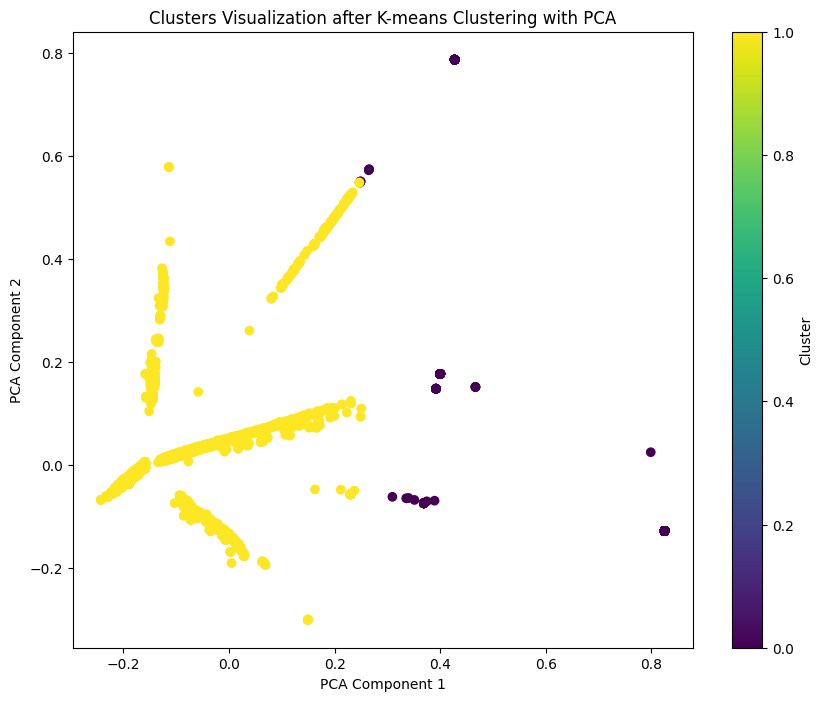

In [37]:
# Reducing dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2) 
X_pca_rdf = pca.fit_transform(X_train_rdf_vec.toarray())

# Clusters plotting
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_rdf[:, 0], X_pca_rdf[:, 1], c=predicted_labels_rdf, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization after K-means Clustering with PCA')
plt.colorbar(label='Cluster')
plt.savefig('Clusters_K-means_FACTS_PCA.png')
plt.show()


#### Compute supervised and unsupervised metrics and visualizations to compare results

In [38]:
#Supervised, and Unsupervised(Silhouette) Metrics

from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train_rdf, predicted_labels_rdf))
print("Completeness: %0.3f" % metrics.completeness_score(y_train_rdf, predicted_labels_rdf))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train_rdf, predicted_labels_rdf))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_train_rdf, predicted_labels_rdf))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X_train_rdf_vec, predicted_labels_rdf))



Homogeneity: 0.147
Completeness: 0.210
V-measure: 0.173
Adjusted Rand-Index: -0.006
Silhouette Coefficient: 0.131


# Part 2: Comparing two NLP Packages: Stanza and Spacy

## 1: Named entity Recognition

Write a function that will process one document (i.e. a biography)
and return the set of named entities (NE) detected within it. Do
this for both Spacy and Stanza. Store your results where (e.g.
Pandas dataframe/json file) you can easily retrieve them to do
comparisons

Named Entity with Spacy

In [56]:
nlp_spacy = spacy.load('en_core_web_sm')

In [57]:
def spacy_model(doc):
    """
    Processes a document using SpaCy to extract named entities.

    Input:
    - doc (str): The document to be processed.

    Output:
    - list: A list of tuples containing entity text and its label.
    """
    doc_spacy = nlp_spacy(doc)
    spacy_entities = [(ent.text, ent.label_) for ent in doc_spacy.ents]

    return spacy_entities



Named Entity with Stanza

In [58]:
# Same as above but with Stanza
nlp_stanza = stanza.Pipeline('en', processors='tokenize,ner', tokenize_pretokenized=True)

2024-06-14 10:09:09 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-06-14 10:09:09 INFO: Downloaded file to C:\Users\belen\stanza_resources\resources.json
2024-06-14 10:09:10 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| ner       | ontonotes-ww-multi_charlm |

2024-06-14 10:09:10 INFO: Using device: cpu
2024-06-14 10:09:10 INFO: Loading: tokenize
2024-06-14 10:09:10 INFO: Loading: ner
2024-06-14 10:09:15 INFO: Done loading processors!


In [59]:
def stanza_model(doc):
    """
    Processes a document using SpaCy for tokenization and Stanza for named entity recognition.

    Input:
    - doc (str): The document to be processed.

    Output:
    - list: A list of tuples containing entity text and its type from Stanza.
    """
    doc_spacy = nlp_spacy(doc) 
    spacy_tokens = [[token.text for token in sent] for sent in doc_spacy.sents]
    
    # Process the tokenized text with Stanza
    doc_stanza = nlp_stanza(spacy_tokens)
    
    # Extract named entities from Stanza output
    stanza_entities = []
    for sent in doc_stanza.sentences:
        for ent in sent.ents:
            stanza_entities.append((ent.text, ent.type))
    
    return stanza_entities


In [60]:
#Execution of these two functions to NER

df['ner_spacy'] = df['text'].apply(spacy_model)
df['ner_stanza'] = df['text'].apply(stanza_model)

df.to_csv('4_NER_Spacy_Stanza_initial.csv')

Report basic statistics about the predicted set of NEs by each package (i.e. Spacy vs Stanza). This should include:

| avg/min/max number of NEs. Report this per category per package

In [61]:
#Spacy avg min max 
def count_named_entities(entities):
    """
    Counts the number of named entities in the input list.

    Input:
    - entities (list): A list of named entities.

    Output:
    - int: The count of named entities. Returns 0 if the input is not a list.
    """
    # Ensure the input is a list
    if isinstance(entities, list):
        return len(entities)
    elif isinstance(entities, str):
        ent_list = ast.literal_eval(entities)
        return len(ent_list)
    else:
        return 0

#Execution of the function
df['ner_count_spacy'] = df['ner_spacy'].apply(count_named_entities)

#Extraction of averages
avg_ner_spacy = df['ner_count_spacy'].mean()
min_ner_spacy = df['ner_count_spacy'].min()
max_ner_spacy = df['ner_count_spacy'].max()

print(f'The average of NER for spacy is: {avg_ner_spacy}')
print(f'The min NER for Spacy is: {min_ner_spacy}')
print(f'The max NER for Spacy is: {max_ner_spacy}')

#Stanza avg min max

# Apply the function to the ner_stanza column
df['ner_count_stanza'] = df['ner_stanza'].apply(count_named_entities)

# Calculate average, min, and max for ner_stanza
avg_ner_stanza = df['ner_count_stanza'].mean()
min_ner_stanza = df['ner_count_stanza'].min()
max_ner_stanza = df['ner_count_stanza'].max()

#visualization of the average
print(f'The average of NER for stanza is: {avg_ner_stanza}')
print(f'The min NER for stanza is: {min_ner_stanza}')
print(f'The max NER for stanza is: {max_ner_stanza}')

df.to_csv('5_NER_Spacy_Stanza_Stats.csv')


The average of NER for spacy is: 160.475
The min NER for Spacy is: 11
The max NER for Spacy is: 1491
The average of NER for stanza is: 165.785
The min NER for stanza is: 10
The max NER for stanza is: 1510


| avg/min/max number of words in each NE. Report this per
category per package

In [62]:
# avg/min/max number of words

#For Spacy
def count_words_in_entities(entities):
    """
    Counts the number of words in each entity [first item of the tuple] from the input list.

    Input:
    - entities (list): A list of tuples in the form: (entity, type), or a string if data stored in a csv

    Output:
    - list: A list of integers representing the word count for each entity.
    """
    if isinstance(entities, str):
        entities = ast.literal_eval(entities)
        
    word_counts = [len(item[0].split()) for item in entities]
    return word_counts

    
df['word_count_sp'] = df['ner_spacy'].apply(count_words_in_entities)

all_word_counts = [count for sublist in df['word_count_sp'] for count in sublist]

#Extraction of metrics
avg_words_per_entity_sp = sum(all_word_counts) / len(all_word_counts) if all_word_counts else 0
min_words_per_entity_sp = min(all_word_counts) if all_word_counts else 0
max_words_per_entity_sp = max(all_word_counts) if all_word_counts else 0

#visualization of metrics
print(f'The average number of words per NER for Spacy is: {avg_words_per_entity_sp}')
print(f'The min amount of words per entity for Spacy is: {min_words_per_entity_sp}')
print(f'The max amount of words per entity for Spacy is: {max_words_per_entity_sp}')


# Apply the function to the 'ner_stanza' column
df['word_count_st'] = df['ner_stanza'].apply(count_words_in_entities)

all_word_counts_st = [count for sublist in df['word_count_st'] for count in sublist]

#Extraction of metrics
avg_words_per_entity_st = sum(all_word_counts_st) / len(all_word_counts_st) if all_word_counts_st else 0
min_words_per_entity_st = min(all_word_counts_st) if all_word_counts_st else 0
max_words_per_entity_st = max(all_word_counts_st) if all_word_counts_st else 0

#Visualization of metrics
print(f'The average number of words per NER for Stanza is: {avg_words_per_entity_st}')
print(f'The min amount of words per entity for Stanza is: {min_words_per_entity_st}')
print(f'The max amount of words per entity for Stanza is: {max_words_per_entity_st}')

df.to_csv('6_NER_Spacy_Stanza_Stats_II.csv')


The average number of words per NER for Spacy is: 1.7812431842966194
The min amount of words per entity for Spacy is: 1
The max amount of words per entity for Spacy is: 19
The average number of words per NER for Stanza is: 2.0201164158397926
The min amount of words per entity for Stanza is: 1
The max amount of words per entity for Stanza is: 31


Use visualisation to compare the above 2 statistics, per category
per package.

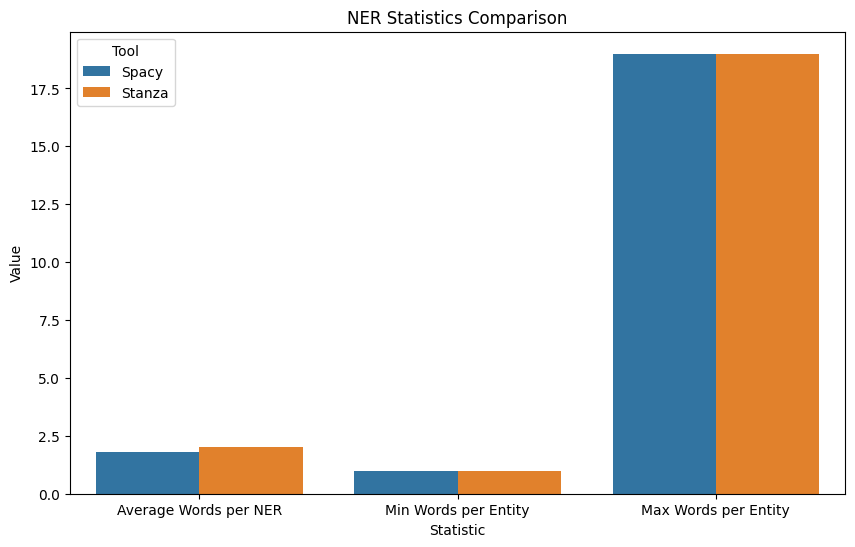

In [63]:
# Data
data = {
    'Statistic': ['Average Words per NER', 'Min Words per Entity', 'Max Words per Entity', 
                  'Average Words per NER', 'Min Words per Entity', 'Max Words per Entity'],
    'Value': [avg_words_per_entity_sp, min_words_per_entity_sp, max_words_per_entity_sp, avg_words_per_entity_st, min_words_per_entity_sp , max_words_per_entity_sp],
    'Tool': ['Spacy', 'Spacy', 'Spacy', 'Stanza', 'Stanza', 'Stanza']
}

# Create DataFrame
df_visual = pd.DataFrame(data)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Statistic', y='Value', hue='Tool', data=df_visual)
plt.title('NER Statistics Comparison')
plt.ylabel('Value')
plt.xlabel('Statistic')
plt.legend(title='Tool')
plt.savefig('Barplot_NER_Stats.png')
plt.show()



In [64]:
def report_statistics(df):
    statistics = {
        'spacy': {
            'avg_count': avg_ner_spacy,
            'min_count': min_ner_spacy,
            'max_count': max_ner_spacy,
            'avg_words_per_ne': avg_words_per_entity_sp,
            'min_words_per_ne': min_words_per_entity_sp,
            'max_words_per_ne': max_words_per_entity_sp,
        },
        'stanza': {
            'avg_count': avg_ner_stanza,
            'min_count': min_ner_stanza,
            'max_count': max_ner_stanza,
            'avg_words_per_ne': avg_words_per_entity_st,
            'min_words_per_ne': min_words_per_entity_st,
            'max_words_per_ne': max_words_per_entity_st
        }
    }
    return statistics

statistics = report_statistics(df)
print(statistics)

{'spacy': {'avg_count': 160.475, 'min_count': 11, 'max_count': 1491, 'avg_words_per_ne': 1.7812431842966194, 'min_words_per_ne': 1, 'max_words_per_ne': 19}, 'stanza': {'avg_count': 165.785, 'min_count': 10, 'max_count': 1510, 'avg_words_per_ne': 2.0201164158397926, 'min_words_per_ne': 1, 'max_words_per_ne': 31}}


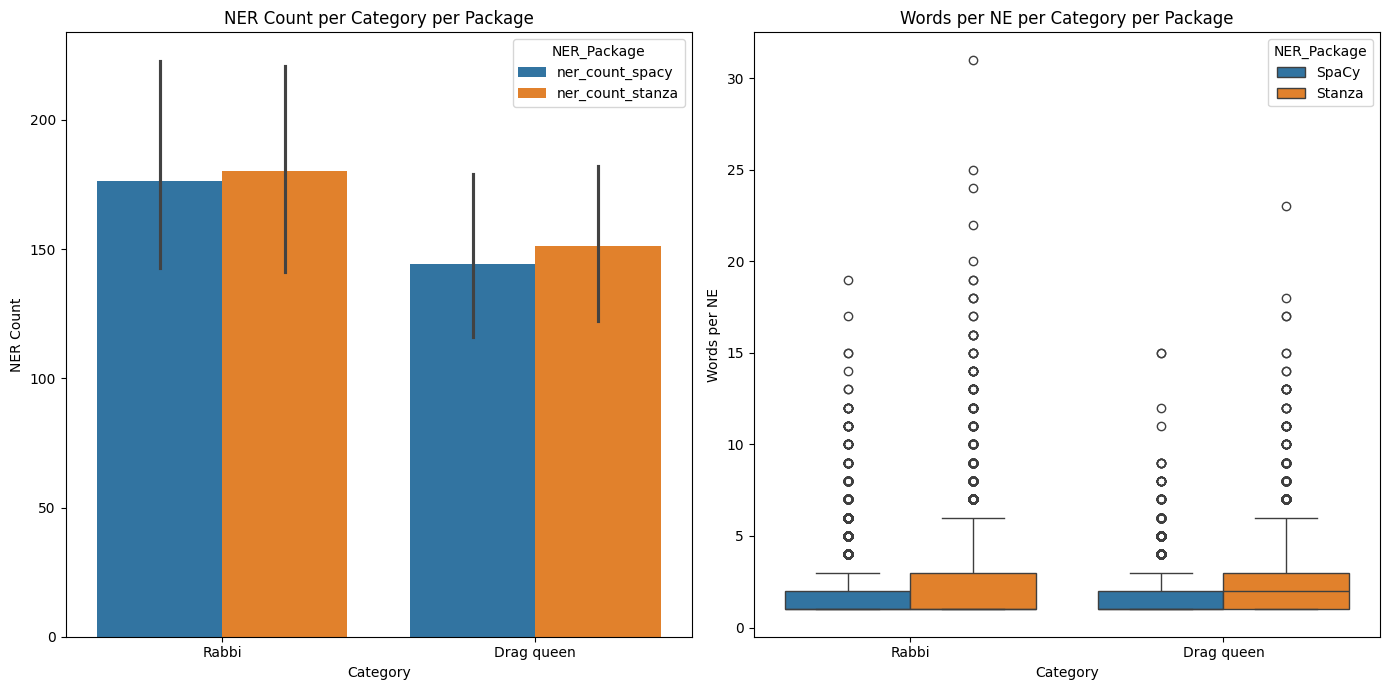

In [65]:
def visualize_statistics(df):
    # Melting the DataFrame for easier plotting with Seaborn
    df_melted = df.melt(id_vars=['category'], value_vars=['ner_count_spacy', 'ner_count_stanza'],
                        var_name='NER_Package', value_name='NER_Count')
    
    plt.figure(figsize=(14, 7))

    # Plotting the number of NEs per category per package
    plt.subplot(1, 2, 1)
    sns.barplot(x='category', y='NER_Count', hue='NER_Package', data=df_melted)
    plt.title('NER Count per Category per Package')
    plt.xlabel('Category')
    plt.ylabel('NER Count')

    words_per_ne_data = {
        'category': [],
        'words_per_ne': [],
        'NER_Package': []
    }
    
    for idx, row in df.iterrows():
        for words in row['word_count_sp']:
            words_per_ne_data['category'].append(row['category'])
            words_per_ne_data['words_per_ne'].append(words)
            words_per_ne_data['NER_Package'].append('SpaCy')
        for words in row['word_count_st']:
            words_per_ne_data['category'].append(row['category'])
            words_per_ne_data['words_per_ne'].append(words)
            words_per_ne_data['NER_Package'].append('Stanza')

    df_words_per_ne = pd.DataFrame(words_per_ne_data)

    plt.subplot(1, 2, 2)
    sns.boxplot(x='category', y='words_per_ne', hue='NER_Package', data=df_words_per_ne)
    plt.title('Words per NE per Category per Package')
    plt.xlabel('Category')
    plt.ylabel('Words per NE')

    plt.tight_layout()
    plt.savefig('NER_Count_Per_Package.png')
    plt.show()
    

visualize_statistics(df)


## 2: Named Entity Recognition: analysis by entity type

Write a function that checks one document (i.e. a biography) for
the following:
1. the number of spans (i.e. token(s)) where both packages agree
and predict is an NE (i.e. complete overlap in span predicted).
2. the number of spans where there is a partial agreement between
both packages (i.e. partial overlap in spans predicted).
3.  for each package, the number of spans that a package predicted
as an NE, but the other package did not predict as an NE.
4.  for the spans with full and partial agreement, was there an
agreement in the NE type (e.g. Person, Location, Organisation
etc)
5. Use visualisation to compare the above statistics, per category
per package (i.e. Spacy vs Stanza)

In [66]:
def agreement_counter(ner_spacy, ner_stanza):
    """
    Counts the agreements and disagreements between SpaCy and Stanza named entity recognitions.

    Input:
    - ner_spacy (str): A string representation of a list of tuples from SpaCy NER output.
    - ner_stanza (str): A string representation of a list of tuples from Stanza NER output.

    Output:
    - tuple:
        - int: Count of full text agreements.
        - int: Count of partial agreements.
        - int: Count of full text and type agreements.
        - int: Count of entities only recognized by SpaCy.
        - int: Count of entities only recognized by Stanza.
    """
    # Converting the string to a list of tuples
    #ner_spacy = ast.literal_eval(ner_spacy)
    #ner_stanza = ast.literal_eval(ner_stanza)
    # Taking only the text of entities from the tuple
    text_spacy = [entity[0] for entity in ner_spacy]
    text_stanza = [entity[0] for entity in ner_stanza]

    # Creating the set of entity texts
    set_spacy = set((text_spacy))
    set_stanza = set((text_stanza))

    # Creating set for the whole entity including text and type
    set_entities_spacy = set(ner_spacy)
    set_entities_stanza = set(ner_stanza)

    # Full text agreements using set intersection
    full_agreements = set_spacy & set_stanza
    full_agreement_count = len(full_agreements)

    # Full text and type agreements using set intersection
    full_type_agreements = set_entities_spacy & set_entities_stanza
    type_agreement_count = len(full_type_agreements)

    # Partial agreements
    partial_agreement_count = 0

    # Removed full agreements from the sets to avoid double counting
    remaining_sp = set_entities_spacy - full_type_agreements
    remaining_st = set_entities_stanza - full_type_agreements

    # Checking for partial agreements
    for ent_spacy, label_spacy in remaining_sp:
        for ent_stanza, label_stanza in remaining_st:
            if ent_spacy in ent_stanza or ent_stanza in ent_spacy:
                partial_agreement_count += 1
                if label_spacy == label_stanza:
                    type_agreement_count += 1

    # Spans predicted by one package but not the other
    only_spacy = len(set_spacy - set_stanza)
    only_stanza = len(set_stanza - set_spacy)
    
    return full_agreement_count, partial_agreement_count, type_agreement_count, only_spacy, only_stanza


#row = df.iloc[0]
#res = agreement_counter(row['ner_spacy'], row['ner_stanza'])

df['complete_overlap'], df['partial_overlap'], df['type_overlap'], df['only_spacy'], df['only_stanza']= zip(*df.apply(lambda row: agreement_counter(row['ner_spacy'], row['ner_stanza']), axis=1))
df.to_csv('7_Final_Processed_Data.csv')



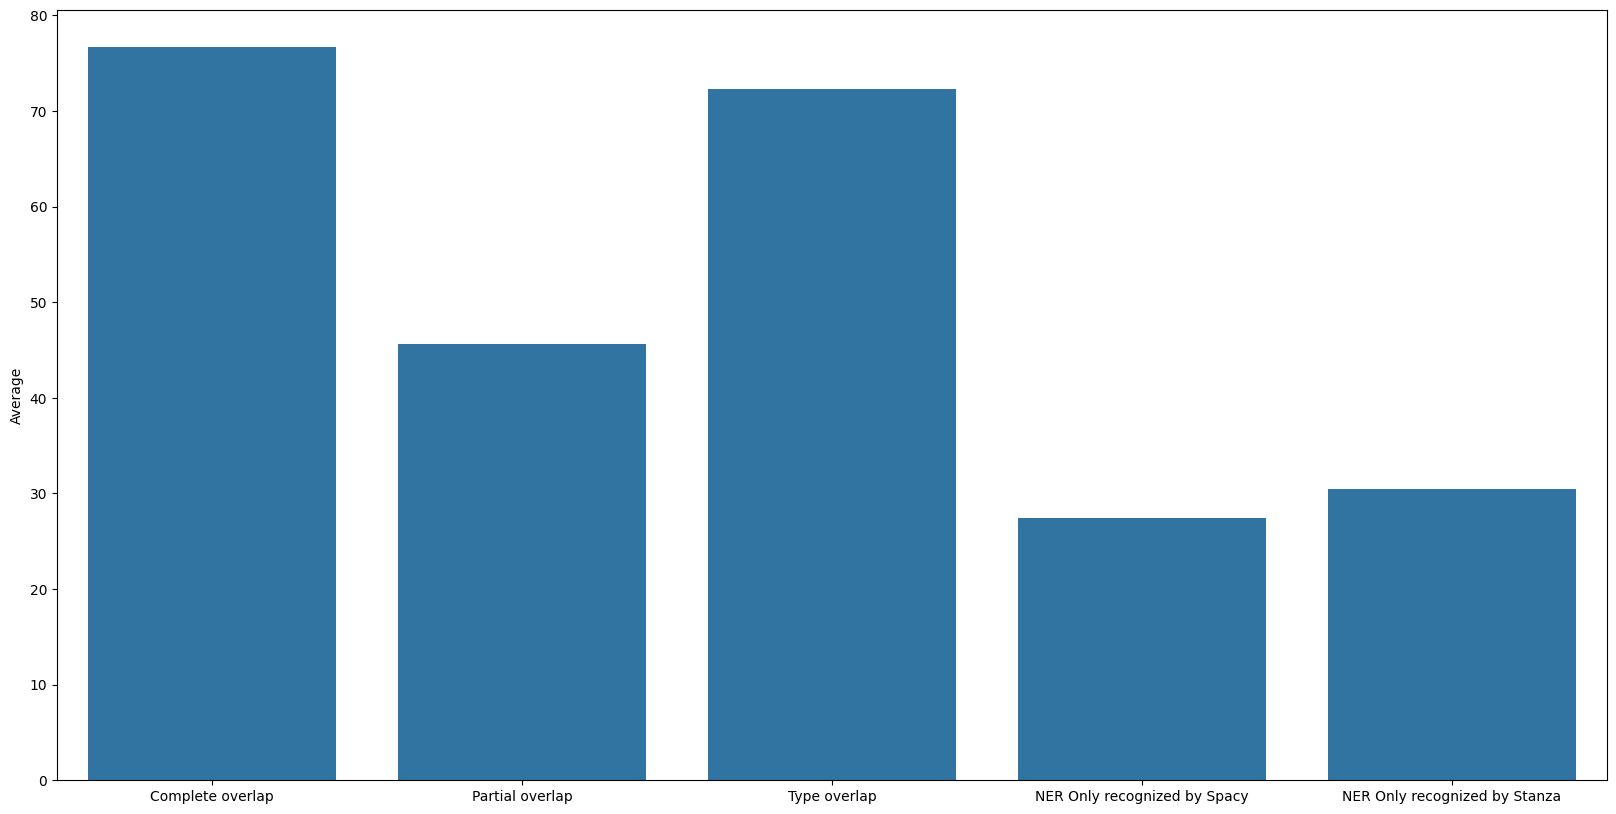

In [67]:

dict_visual = {  
        'Complete overlap': df['complete_overlap'].mean(),
        'Partial overlap': df['partial_overlap'].mean(),
        'Type overlap': df['type_overlap'].mean(),
        'NER Only recognized by Spacy': df['only_spacy'].mean(),
        'NER Only recognized by Stanza': df['only_stanza'].mean()
    }

  
df_visual = pd.DataFrame.from_dict(dict_visual, orient = 'index', columns=['Average'])

plt.figure(figsize=(20, 10))
sns.barplot(df_visual, x=['Complete overlap', 'Partial overlap', 'Type overlap', 'NER Only recognized by Spacy','NER Only recognized by Stanza'], y="Average")
plt.savefig('General_Stats_NER.png')
plt.show()

## 3: Named Entity Recognition: verification against knowledge graph

Write a function that checks the following for each person:
1. for each set of NEs predicted by each package (i.e. Stanza and
Spacy), how many of them can be found mentioned in the KG
Graph you collected for the person?
2. return for each package (i.e. Stanza and Spacy), the ratio of
predicted NEs that you can be confidently said to be in the KG
graph for the person

In [3]:

df = pd.read_csv(fr'C:\Users\belen\Desktop\Université de Lorraine\Second semester\Data_science_FinalProject\stanza_and_spacy_comparison\8_NER_Spacy_STATS_FULL_FINAL.csv')

In [6]:
print(type(df['ner_stanza'][0]))

<class 'list'>


In [5]:
df['ner_stanza'] = df['ner_stanza'].apply(ast.literal_eval)
df['ner_spacy'] = df['ner_spacy'].apply(ast.literal_eval)

In [7]:
def check_entity_in_dbpedia(entity, retries=3, delay=5):
    """
    Checks if an entity exists in DBpedia with retries for failure.

    Input:
    - entity (str): The entity to check in DBpedia.
    - retries (int, optional): The number of retry attempts in case of failure. Default is 3.
    - delay (int, optional): The delay in seconds between retries. Default is 5.

    Output:
    - bool: True if the entity exists in DBpedia, False otherwise.
    """
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    query = f"""
    ASK WHERE {{
        {{ ?s rdfs:label "{entity}"@en }} UNION
        {{ ?s rdfs:label "{entity}"@es }}
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('POST')  # Get Method was problematic

    for attempt in range(retries):
        try:
            results = sparql.query().convert()
            return results['boolean']
        except (HTTPError, EndPointNotFound, QueryBadFormed, EndPointInternalError):
            if attempt < retries - 1:
                time.sleep(delay)
            else:
                return False
        except Exception:
            return False

def custom_literal_eval(entities_str):
    """
    Custom function to parse a string representation of a list of entities.

    Input:
    - entities_str (str): The string representation of a list of entities.

    Output:
    - list: A list of parsed entities.
    """
    entities_str = entities_str.strip("[]")
    entities_list = re.split(r',\s*(?=(?:[^"]*"[^"]*")*[^"]*$)', entities_str)
    entities_list = [entity.strip().strip('"').strip("'") for entity in entities_list]
    return entities_list

def process_single_entity(entity):
    """
    Processes a single entity, checks its existence in DBpedia.

    Input:
    - entity (str): The entity to process.

    Output:
    - bool: True if the entity is found in DBpedia, False otherwise.
    """
    entity = entity.strip()
    return check_entity_in_dbpedia(entity)

def process_entities(entities):
    """
    Processes a list of entities, checks their existence in DBpedia, and calculates the percentage of found entities.

    Input:
    - entities (list): The list of entities to process.

    Output:
    - tuple:
        - list: A list of entities found in DBpedia.
        - float: The percentage of entities found in DBpedia.
    """
    try:
        entities_list = (entity[0] for entity in entities)
    except (ValueError, SyntaxError):
        return [], 0  
    
    found_entities = []
    total_entities = 0
    for entity in entities_list:
        if process_single_entity(entity):
            found_entities.append(entity)
        total_entities += 1

    percentage = (len(found_entities) / total_entities * 100) if total_entities else 0
    return found_entities, percentage

# Function to process entities in batches
def process_entities_batch(df, column_name, batch_size=50):
    total_rows = df.shape[0]
    num_batches = (total_rows // batch_size) + (1 if total_rows % batch_size != 0 else 0)

    results = []
    percentages = []

    overall_progress = tqdm(total=num_batches * batch_size, desc=f"Processing {column_name} entities", unit='entity')

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, total_rows)
        batch = df.iloc[start_idx:end_idx]

        try:
            batch_results, batch_percentages = zip(*batch[column_name].apply(process_entities))
            results.extend(batch_results)
            percentages.extend(batch_percentages)
        except Exception as e:
            continue

        
        overall_progress.update(batch_size)

        
        del batch
        gc.collect()

    overall_progress.close()
    return results, percentages

# careful: very time consuming code.
df['ner_spacy_KG'], df['ner_spacy_KG_percentage'] = process_entities_batch(df, 'ner_spacy', batch_size=10)
df['ner_stanza_KG'], df['ner_stanza_KG_percentage'] = process_entities_batch(df, 'ner_stanza', batch_size=10) 

# Save the processed dataframe to avoid data loss
df.to_csv('9_NER_Spacy_Stanza_Full.csv', index=False) 


Processing ner_stanza entities:   0%|          | 0/200 [00:00<?, ?entity/s]

Processing ner_stanza entities: 100%|██████████| 200/200 [3:38:54<00:00, 65.67s/entity]  


In [8]:
df.head()

,Unnamed: 0.1,Unnamed: 0,text,category,clean_text,tokenized,ner_spacy,ner_stanza,ner_count_spacy,ner_count_stanza,...,word_count_st,complete_overlap,partial_overlap,type_overlap,only_spacy,only_stanza,ner_spacy_KG,ner_spacy_KG_percentage,ner_stanza_KG,ner_stanza_KG_percentage
0,0,0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi,capers c funnye jr born april 14 1952 i...,"['capers', 'c', 'funnye', 'jr', 'born', 'april...","[(April 14, 1952, DATE), (African-American, NO...","[(Capers C. Funnye Jr., PERSON), (April 14 , 1...",188,204,...,"[4, 4, 3, 1, 7, 1, 1, 3, 3, 1, 2, 1, 1, 2, 1, ...",102,45,94,19,27,"['African-American', '200', 'Illinois', 'Georg...",69.680851,"[Capers C. Funnye Jr., 200, Beth Shalom B'nai ...",67.156863
1,1,1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi,samuel adler december 3 1809 – june 9 1891 ...,"['samuel', 'adler', 'december', '3', '1809', '...","[(Samuel Adler, PERSON), (December 3, 1809 – J...","[(Samuel Adler, PERSON), (December 3 , 1809, D...",171,176,...,"[2, 4, 4, 3, 1, 2, 4, 6, 1, 1, 1, 1, 1, 1, 1, ...",87,41,75,37,34,"['Samuel Adler', 'German', 'Talmudist', 'Samue...",70.175439,"[Samuel Adler, Talmudist, Samuel Adler, German...",72.159091
2,2,2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi,elie abadie arabic ايلي عبادي is senior rab...,"['elie', 'abadie', 'arabic', 'ايلي', 'عبادي', ...","[(Elie Abadie, PERSON), (Arabic, NORP), (the J...","[(Elie Abadie, PERSON), (Arabic, LANGUAGE), (R...",108,114,...,"[2, 1, 1, 6, 6, 1, 8, 2, 2, 4, 5, 1, 1, 2, 1, ...",66,23,60,13,16,"['Elie Abadie', 'Arabic', 'JCE', 'Yeshiva Univ...",68.518519,"[Elie Abadie, Arabic, Rabbi, JCE, Yeshiva Univ...",71.052632
3,3,3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi,menahem shemuel halevy hebrew מנחם שמואל הלו...,"['menahem', 'shemuel', 'halevy', 'hebrew', 'מנ...","[(Shemuel Halevy, PERSON), (Hebrew, LANGUAGE),...","[(Menahem Shemuel Halevy, PERSON), (Hebrew, LA...",407,417,...,"[3, 1, 1, 1, 4, 1, 1, 5, 1, 1, 1, 1, 1, 4, 1, ...",180,125,164,60,92,"['Hebrew', 'Iranian', 'Iran', 'Halevy', 'first...",62.653563,"[Menahem Shemuel Halevy, Hebrew, Iranian, Iran...",58.513189
4,4,4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi,rabbi menachem mendel monsohn hebrew מנחם מע...,"['rabbi', 'menachem', 'mendel', 'monsohn', 'he...","[(Mendel Monsohn, PERSON), (Hebrew, LANGUAGE),...","[(Rabbi Menachem Mendel Monsohn, PERSON), (Heb...",102,105,...,"[4, 1, 4, 4, 1, 1, 3, 1, 4, 1, 1, 1, 1, 4, 5, ...",53,23,49,16,19,"['Hebrew', 'Monsohn', 'Jerusalem', 'Jerusalem'...",65.686275,"[Rabbi Menachem Mendel Monsohn, Hebrew, Monsoh...",64.761905


In [10]:
df['number_ner_stanza'] = [len(list_ent) for list_ent in df['ner_stanza_KG']]
df['number_ner_spacy'] = [len(list_ent) for list_ent in df['ner_spacy_KG']]

df.to_csv('10_Final_processing_data.csv')
